In [1]:
import numpy as np
import os, sys
import pandas as pd
import scipy.stats
import scipy.io as spio


# root directory is 2 dirs up from this file
# path = os.path.realpath(__file__).split('/')
# root = '/'+os.path.join(*path[0:-3])
root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))


import matplotlib.pyplot as plt

from code_utils import data_utils, file_utils

import scipy.io as spio
import deconv

In [2]:
h, trial_cond_names, roi_names = deconv.get_hrfs_maintask(ss=1, nTRs_to_model=20)

0.33625071584499694
-0.015318025479652324
0.32551562878845614
-0.007869923806512559
0.3203251936361581
-0.006288060121702056
0.3719165484948888
-0.006305592723341063
0.28240856457082564
-0.006523603538799095
0.292598099660344
-0.005362192266895424
0.22829200086334178
-0.008147104793187091
0.25358337093252
-0.0030524199449831653
0.27964636467504456
-0.0055822688967463755
0.27603729956624
-0.005493300520916563
0.1966880787195908
-0.0008295705239027566


In [3]:
ss = 1;
nTRs_to_model = 20; use_bigIPS = True; concat_IPS = True

In [4]:
if use_bigIPS:
    sample_fn = os.path.join(root, 'Samples','SampleFile_bigIPS_S%02d.mat'%ss)
else:
    sample_fn = os.path.join(root, 'Samples','SampleFile_S%02d.mat'%ss)


sample_fn = os.path.join(root, 'Samples','SampleFile_bigIPS_S%02d.mat'%ss)

samples = file_utils.load_samplefile_h5py(sample_fn)

samples['all_vox_concat'].shape

# load the "timing" file (what happened on each TR)
# this is made in GetEventTiming.m
timing_fn = os.path.join(root, 'Samples','TimingFile_S%02d.mat'%ss)
# print('loading from %s'%timing_fn)
timing = spio.loadmat(timing_fn, squeeze_me=True, struct_as_record=False)
main = file_utils._todict(timing['main'])
rep = file_utils._todict(timing['rep'])

# load the behav data structure, this is [n_trials,] and has more trial attributes
behav_fn = os.path.join(root, 'DataBehavior', 'S%02d'%ss, \
                                      'S%02d_maintask_preproc_all.csv'%ss)
# print('loading from %s'%behav_fn)
bdat = pd.read_csv(behav_fn, index_col=0)

roi_names = samples['ROI_names']
n_rois = len(roi_names)
n_hemis = len(samples['hemis'])

h = []


In [5]:
rr = 0;

dat_this_roi = []

for hh in range(n_hemis):

    roi_inds_num = np.array(samples['ROIs']['voxel_inds'][rr][hh])

    inds_this_hemi = np.isin(np.array(samples['all_vox_concat']), roi_inds_num)[:,0]

    if np.sum(inds_this_hemi)>0:
        # print(np.sum(inds_this_hemi))
        # samples['samplesMain'] is originally [n_vox x nTRs]
        # transpose because i want [nTRs x n_vox]
        dat_this_hemi = samples['samplesMain'][inds_this_hemi,:].T
        dat_this_roi += [dat_this_hemi]

dat_this_roi = np.concatenate(dat_this_roi, axis=1)

# count things, check the counts
nTRs = 327-16;
nTRs_total, n_vox = dat_this_roi.shape
assert(np.mod(nTRs_total, nTRs)==0)
n_runs = int(nTRs_total / nTRs)

run_labels = np.array(main['RunLabels'])
assert(n_runs==len(np.unique(run_labels)))
assert(nTRs_total==len(run_labels))

# zscore the data from each run to normalize.
for run in np.unique(run_labels):

    run_inds = run_labels==run
    assert(np.sum(run_inds)==nTRs)

    dat_this_roi[run_inds,:] = scipy.stats.zscore(dat_this_roi[run_inds,:], axis=0)


In [6]:
# label the onset of each trial
# 1 = stim on, 0 = stim off
event_diff  = np.diff(np.array([0] + main['EventLabels']))
event_diff_reshaped = np.reshape(event_diff, [nTRs, n_runs], order='F')
trial_onset_bool = event_diff_reshaped==1;
trial_onset_bool = np.reshape(trial_onset_bool, [nTRs*n_runs,1], order='F')
trial_onset_num = np.where(trial_onset_bool)[0]

n_trials_per_run = 48
n_trials = n_runs*n_trials_per_run
assert(len(trial_onset_num)==n_trials)
assert(np.all(np.unique(bdat['run_overall'])==np.unique(run_labels)))

# defining the trial conditions we want HRF for
task_names = ['Linear-1','Linear-2','Checker']
trial_type_names = ['Easy','Hard']

n_tasks = 3;
n_trial_types = 2;
# n_trial_conds = n_tasks * n_trial_types + 1
n_trial_conds = n_tasks * n_trial_types

is_main_grid = np.array(bdat['is_main_grid']==1)
task_labs = np.array(bdat['task'])

trial_cond_names = []

# making a matrix of onsets for each trial cond
trial_cond_onsets = np.zeros((nTRs_total,n_trial_conds))

ci = -1
for ti,tt in enumerate([1,2,3]):

    for tyi in range(n_trial_types):

        ci+=1

        # figure out which of the onsets belong to this trial condition
        if tyi==0:
            trial_inds = (task_labs==tt) & is_main_grid
        else:
            trial_inds = (task_labs==tt) & ~is_main_grid

        onsets = trial_onset_num[trial_inds].astype(int)

        trial_cond_onsets[onsets,ci] = 1

        trial_cond_names += ['%s %s'%(task_names[ti], trial_type_names[tyi])]


In [31]:
# # label the onset of each trial
# # 1 = stim on, 0 = stim off
# event_diff  = np.diff(np.array([0] + main['EventLabels']))
# event_diff_reshaped = np.reshape(event_diff, [nTRs, n_runs], order='F')
# trial_onset_bool = event_diff_reshaped==1;
# trial_onset_bool = np.reshape(trial_onset_bool, [nTRs*n_runs,1], order='F')
# trial_onset_num = np.where(trial_onset_bool)[0]

# n_trials_per_run = 48
# n_trials = n_runs*n_trials_per_run
# assert(len(trial_onset_num)==n_trials)
# assert(np.all(np.unique(bdat['run_overall'])==np.unique(run_labels)))


# is_main_grid = np.array(bdat['is_main_grid']==1)
# task_labs = np.array(bdat['task'])
# pt_labs = np.array([bdat['nn_ptx'], bdat['nn_pty']]).T
# grid_pts, grid_labs, counts = np.unique(pt_labs, axis=0, \
#                                              return_inverse=True, return_counts=True)

# # defining the trial conditions we want HRF for
# task_names = ['Linear-1','Linear-2','Checker']
# trial_type_names = ['%.1f,%.1f'%(x,y) for x,y in grid_pts]

# n_tasks = 3;
# n_trial_types = 16;
# # n_trial_conds = n_tasks * n_trial_types + 1
# n_trial_conds = n_tasks * n_trial_types



In [7]:
# trial_cond_names = []

# # making a matrix of onsets for each trial cond
# trial_cond_onsets = np.zeros((nTRs_total,n_trial_conds))

# ci = -1
# for ti,tt in enumerate([1,2,3]):

#     for tyi in range(n_trial_types):

#         ci+=1

#         trial_inds = (task_labs==tt) & (grid_labs==tyi)
#         # # figure out which of the onsets belong to this trial condition
#         # if tyi==0:
#         #     trial_inds = (task_labs==tt) & is_main_grid
#         # else:
#         #     trial_inds = (task_labs==tt) & ~is_main_grid

#         onsets = trial_onset_num[trial_inds].astype(int)

#         trial_cond_onsets[onsets,ci] = 1

#         trial_cond_names += ['%s %s'%(task_names[ti], trial_type_names[tyi])]

# ci+=1
# resp_times = np.array(bdat['rt'])
# resp_times_trs = np.round(resp_times/0.8)

# resp_onsets = trial_onset_num + resp_times_trs
# resp_onsets = resp_onsets[~np.isnan(resp_onsets)].astype(int)

# trial_cond_onsets[resp_onsets,ci] = 1
# trial_cond_names += ['Response']

# do the deconvolution here
# print(np.max(np.abs(np.mean(dat_this_roi, axis=0))))

In [44]:
resp_onsets

array([    2,    10,    14, ..., 10237, 10242, 10246])

In [41]:
trial_cond_onsets.shape

(10263, 7)

In [9]:
data = dat_this_roi; 

nTRs_total, n_vox = data.shape
n_trial_conds = trial_cond_onsets.shape[1]
assert(trial_cond_onsets.shape[0]==nTRs_total)
assert(len(run_labels)==nTRs_total)
n_runs = len(np.unique(run_labels))
nTRs = nTRs_total/n_runs

# there are predictors for each TR of each condition, and for each run
n_conds_total = n_trial_conds * nTRs_to_model + n_runs 

X = np.zeros((nTRs_total, n_conds_total+1))

for ri, rr in enumerate(np.unique(run_labels)):

    run_inds = (run_labels==rr)
    assert(np.sum(run_inds)==nTRs)

    # make predictors for each condition
    # these go in same columns as with other runs
    pred_ind = 0
    for ci in range(n_trial_conds):

        # onsets of all events this condition, this run
        cond_onsets = np.where((trial_cond_onsets[:,ci]==1) & run_inds)[0]

        for tr in range(nTRs_to_model):

            # shift by one TR
            onsets_adj = cond_onsets + tr

            # make sure we are still in current run, not bleeding into next
            onsets_adj = onsets_adj[onsets_adj<nTRs_total]
            onsets_adj = onsets_adj[run_inds[onsets_adj]]
            # assert(np.all(run_inds[onsets_adj]))

            # print(onsets_adj)
            X[onsets_adj,pred_ind] = 1;

            pred_ind+=1

    # make constant predictor for this run
    pred_ind = n_trial_conds * nTRs_to_model + ri
    X[run_inds, pred_ind] = 1

X[:, n_conds_total] = 1;

# check that X is full-rank, not degenerate
assert(np.linalg.matrix_rank(X) >= (X.shape[1]-1))

# solve for beta weights
# b is [n_conds_total x n_vox]
b = np.linalg.pinv(X) @ data

# reshape to [nTRs x n_trial_conds x n_vox]
# this removes the constant-run predictors
hrfs = np.reshape(b[0:n_trial_conds * nTRs_to_model, :], [nTRs_to_model, n_trial_conds, n_vox], order='F')

run_const = b[n_trial_conds * nTRs_to_model:n_conds_total, :]
print(np.max(np.abs(run_const)))
print(np.median((run_const)))

# compute r2 of the model for each voxel
yhat = X @ b

ssres = np.sum((yhat - data)**2, axis=0)
sstot = np.sum((data - np.mean(data, axis=0, keepdims=True))**2, axis=0)

vox_r2 = 1 - (ssres/sstot)


0.4516458676618163
-0.010777574845811934


In [13]:
np.argmax(vox_r2)

198

In [16]:
vox_r2[198]

0.3673864870563043

In [14]:
b[2*3*20:,198]

array([-0.04902286, -0.04925088, -0.08759291, -0.0895521 ,  0.06306626,
        0.06500911, -0.04957379, -0.04900034, -0.09016175, -0.08845344,
        0.06578368,  0.06561987, -0.08741724, -0.09110434,  0.06599294,
        0.06559746, -0.04877019, -0.04957379, -0.09016175, -0.08759291,
        0.06442789,  0.06442789, -0.04902286, -0.04957379,  0.06599294,
        0.06541828, -0.04900069, -0.04898704, -0.08864064, -0.08864064,
        0.06500911,  0.06415776, -0.04863698, -0.04902286, -0.08759291,
       -0.08741724, -0.87326075])

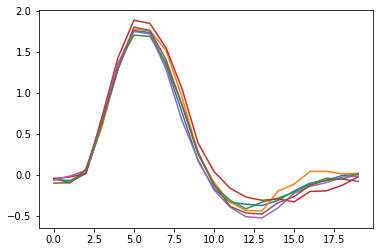

In [15]:
plt.figure()
plt.plot(hrfs[:,:,198])

In [12]:
yhat = X @ b

ssres = np.sum((yhat - data)**2, axis=0)
sstot = np.sum((data - np.mean(data, axis=0, keepdims=True))**2, axis=0)

vox_r2 = 1 - (ssres/sstot)


vox_r2[228]

0.1281604174369414

In [18]:
np.mean(vox_r2)

0.09855120718009268

(array([  28.,  208.,  622., 1503., 2438., 3109., 2346.,  804.,  130.,
           8.]),
 array([-3.62467248, -2.92074825, -2.21682401, -1.51289977, -0.80897554,
        -0.1050513 ,  0.59887294,  1.30279718,  2.00672141,  2.71064565,
         3.41456989]),
 <BarContainer object of 10 artists>)

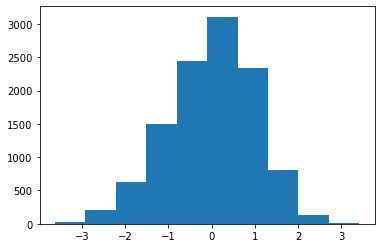

In [17]:
plt.figure()
plt.hist(data[:,198])

In [17]:
np.mean(data[:,228]), np.std(data[:,228])

(-5.980903301712526e-16, 1.0)

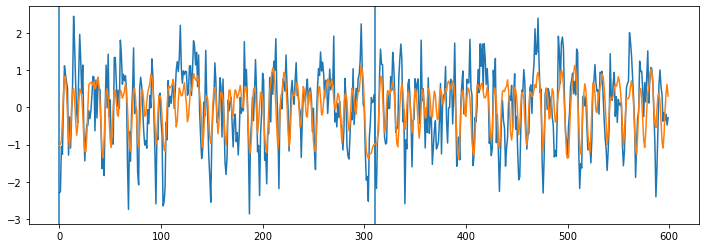

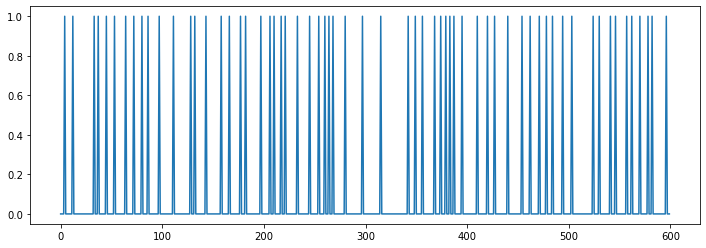

In [20]:
plt.figure(figsize=(12,4))
plt.plot(data[0:600,198])
for vv in np.arange(0, 600, nTRs):
    plt.axvline(vv)
plt.plot(yhat[0:600,198])

plt.figure(figsize=(12,4))
plt.plot(X[0:600,4])

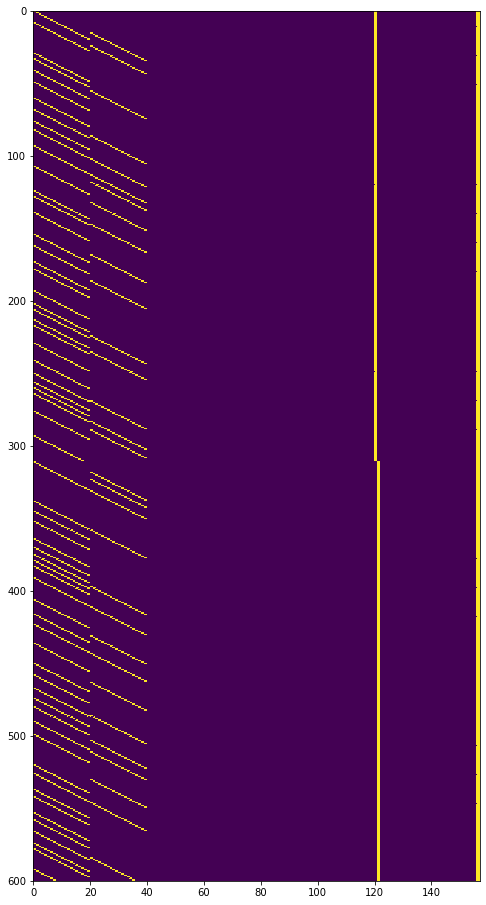

In [21]:
plt.figure(figsize=(8,16))
plt.pcolormesh(X[0:600,:])
plt.gca().invert_yaxis()

In [30]:
np.mean(dat_this_roi[:,0])

5.93590156944671e-16

In [8]:
run_const = h[4]['b'][6*14:,:]
np.min(run_const.ravel()), np.max(run_const.ravel())

(-0.9928268699868922, 0.37399042321559905)

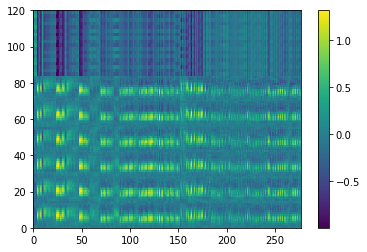

In [10]:
plt.figure()
plt.pcolormesh(h[4]['b'])
plt.colorbar()

In [4]:
b.shape

AttributeError: 'list' object has no attribute 'shape'